In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [193]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [194]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [213]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(predictions)+start_week)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\sigma\,(w_{i}\cdot x_{i}) = \sum_{i=0}^{n} w_{i} x_{i}$$

$$Seasonal\,Part_{0} =\,\cos^2(\dfrac{\pi}{52}\,(x - c)) + k$$

$$Seasonal\,Part_{1} =\,\sin(\dfrac{\pi}{52}\,(x_{\,week\,to\,predict} - c)) + k$$

$$cases = (\sigma(w\cdot x) \,\times Seasonal\,Part) +\, k$$

see whether which seasonality model gives a better result

## Poisson for cost function
- represents how many sigma is it away from mean

In [259]:
def guess(w,x_week,y_case):
    
    def sigma(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        all_cases = np.dot(w[:-3],pad_y)
        return all_cases

    def season_cos_sq(w,x_week):
        pi = np.math.pi
        coeff = pi/52.
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = np.math.cos(inside)**2
        score = cosine_sq + w[-3]
        return score    

#     def season_sin(w,x_week):
#         coeff = np.math.pi / 52.
#         inside = coeff*(x_week - w[-2])
#         score = np.math.sin(inside) + w[-3]
#         return score
    
    return (sigma(w,y_case) * season_cos_sq(w,x_week)) + w[-1]

def get_alphas(LAG,train,constant):
    W_CASE = LAG + 1
    W_POP = 1
    W_SEASON = 2
    BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

    # use poison instead of least square
    def cost(w):
        ret = 0
        for week_no in range(len(train)-LAG):
            week_to_predict = week_no+LAG 
#             print "%d - %d"%(week_no,week_to_predict)
#             print 'pred',train[week_no+LAG]
#             print train[week_no:week_to_predict][0],train[week_no:week_to_predict][-1]
#             print "len",len(train[week_no:week_to_predict])
            real_case = train[week_no+LAG]
            predicted_case = guess(w,week_to_predict,train[week_no:week_to_predict]) # w, 26 (since we start 0-25)
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            ret += ((real_case - predicted_case)**2)/float(sigma_sq)
#         print ret
        return ret

    seasonality_starters = [0.75,20] # [constant,phase]
    arr = np.array([0.]*W_CASE) #  27 betas
#     arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'][:-1])
    arr = np.append(arr,seasonality_starters) # 29 betas
    arr = np.append(arr,constant) # 30 betas
    w = minimize(cost,arr)
    return w

# get_alphas(26,cm_dengues_train,-9.26e-01)

In [235]:
cm_dengues_train[:30]

date
2003-01-05      1
2003-01-12      2
2003-01-19      5
2003-01-26      0
2003-02-02      2
2003-02-09      2
2003-02-16      1
2003-02-23      4
2003-03-02      3
2003-03-09      3
2003-03-16      2
2003-03-23      3
2003-03-30      3
2003-04-06      2
2003-04-13      3
2003-04-20      6
2003-04-27     10
2003-05-04     10
2003-05-11     18
2003-05-18     31
2003-05-25     25
2003-06-01     49
2003-06-08     76
2003-06-15     91
2003-06-22    101
2003-06-29    100
2003-07-06     97
2003-07-13     89
2003-07-20     95
2003-07-27    124
Freq: W-SUN, Name: cases, dtype: int64

### def get_alphas(LAG, train, constant)
function takes in amount of LAG for training, data to train, and starting point for constant
- the function returns set of alphas

each lag yields different accuracy, so it'd be best to see whether which lag gives the best fit with the real plot

In [260]:
cm_26 = get_alphas(26,cm_dengues_train,-9.26e-01)
# cm_52 = get_alphas(52,cm_dengues_train,-9.26e-01)
# cm_78 = get_alphas(78,cm_dengues_train,-9.26e-01)
# cr_26 = get_alphas(26,cr_dengues_train,100)

In [255]:
def plot_prediction(LAG,real,ws,province,nweek_to_predict=[1,2,4,8,12,52]):

    def n_week_ahead(array_x,weeks_ahead,week_no):

        theta = 0
        arr = np.array(array_x)
        for i in range(weeks_ahead):
            week_to_predict = week_no + LAG + i # starting
#             print week_to_predict
            theta = guess(ws,week_to_predict,arr)
            arr = np.append(arr[1:],theta)
        return theta

    for i in nweek_to_predict: # 1,2,4,8,12
        predictions = []
        for j in range(len(real)-LAG):
            initial_arr = real[j:j+LAG]
#             print "initial_arr",initial_arr
            predictions.append(n_week_ahead(initial_arr,i,j)) # 
#         return 
        
        title = "%s's Dengue Prediction %d lags: %d week(s) ahead"%(province,LAG,i)
        make_line(LAG+(i-1),real,predictions,title,"# week starting 2003","cases")

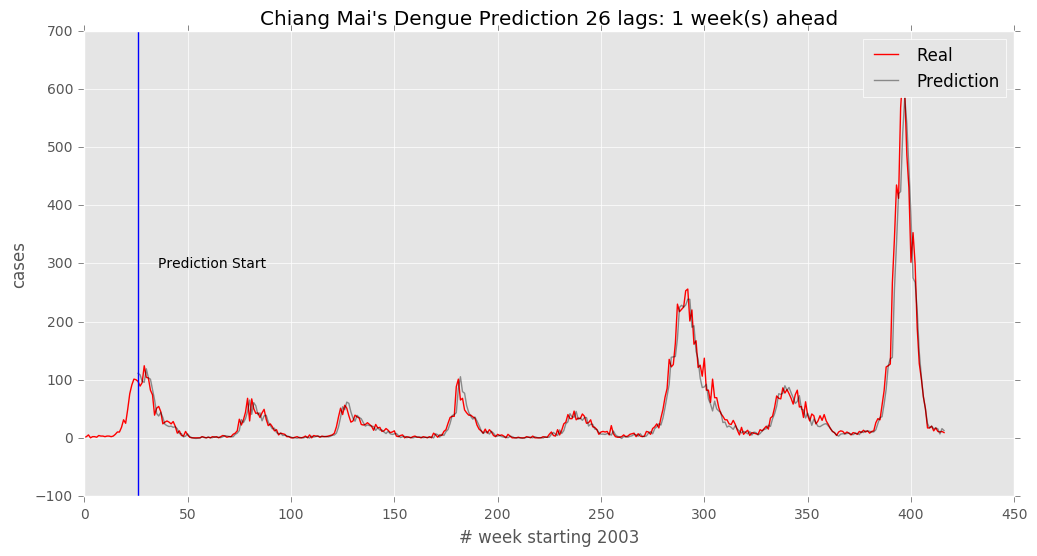

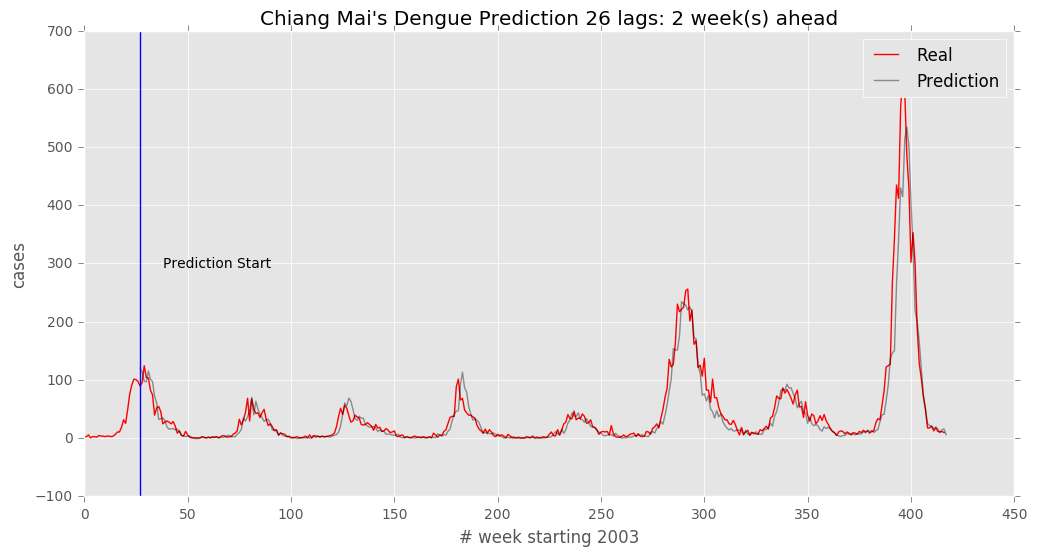

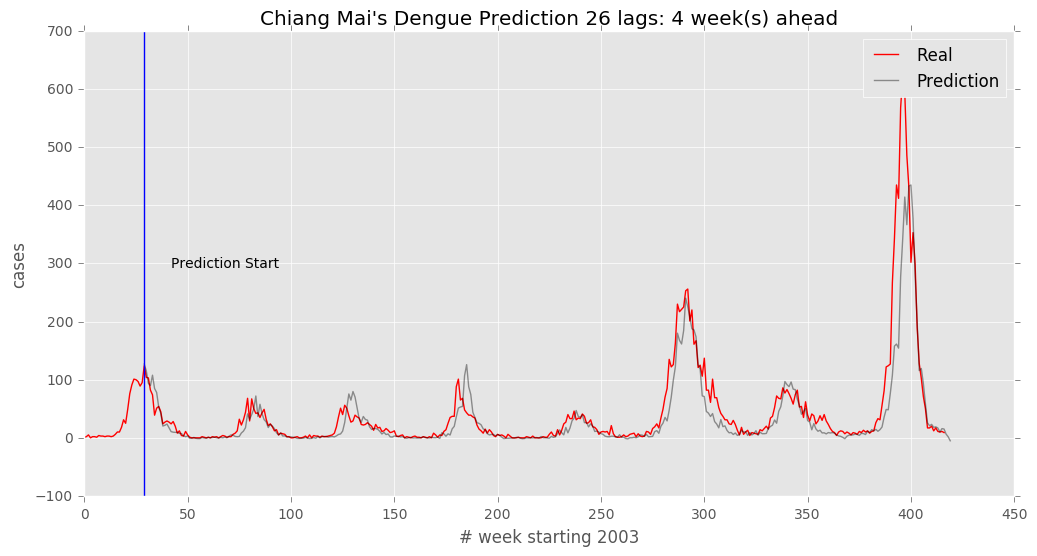

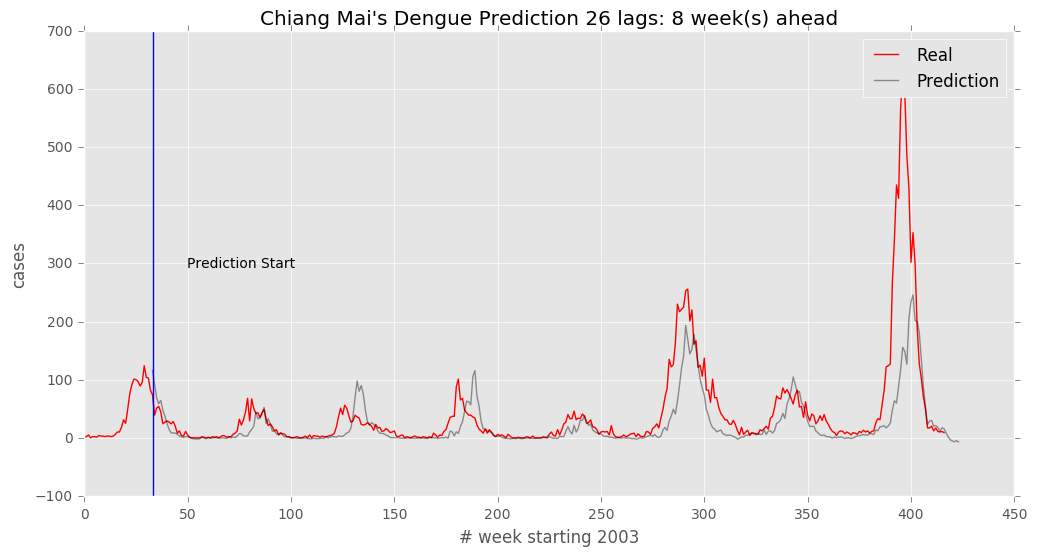

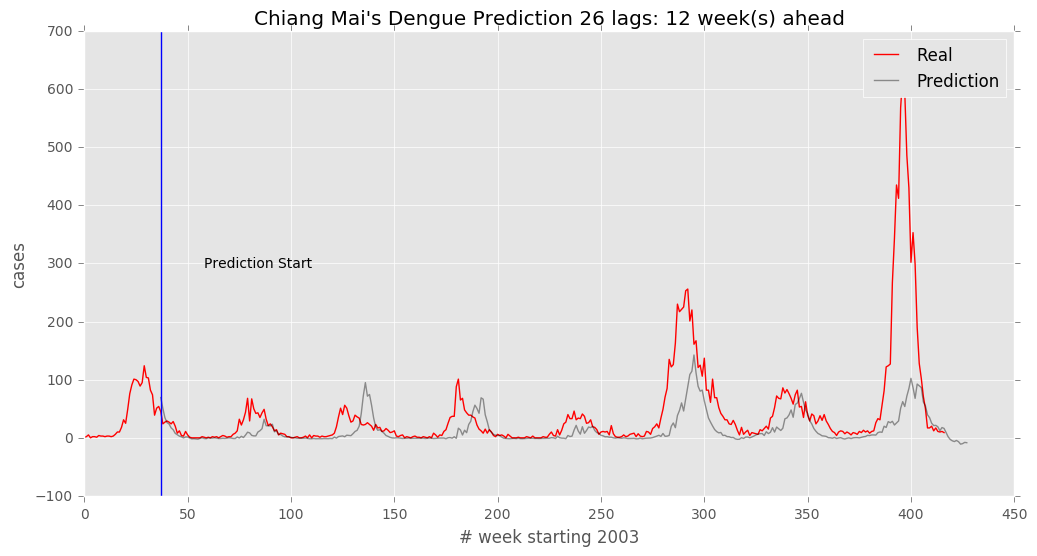

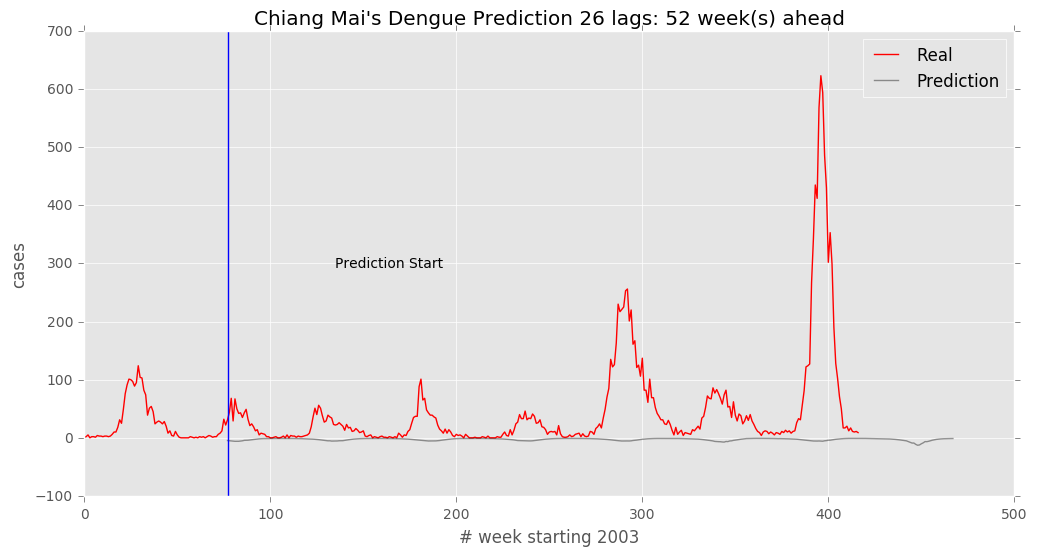

In [261]:
plot_prediction(26,cm_dengues_train,cm_26.x,"Chiang Mai")

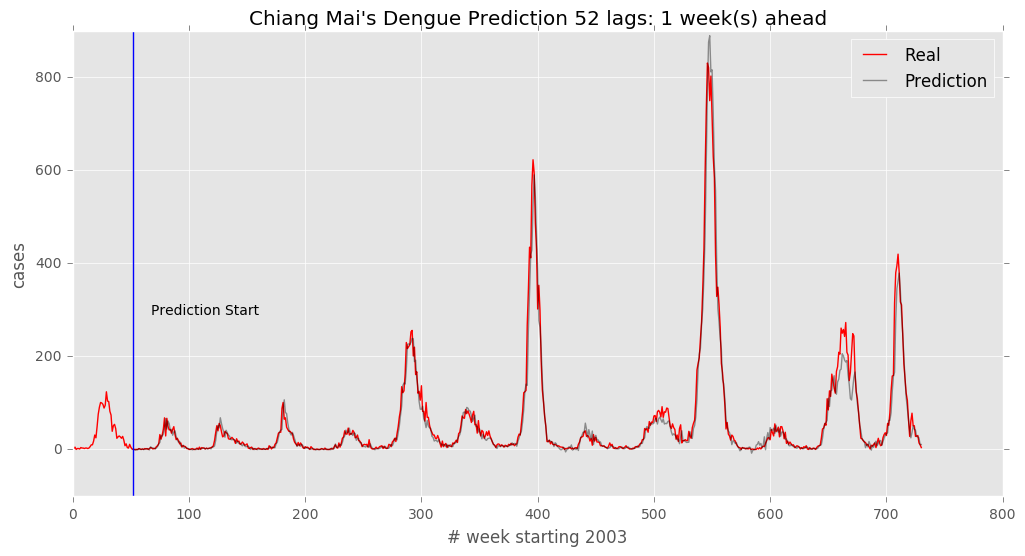

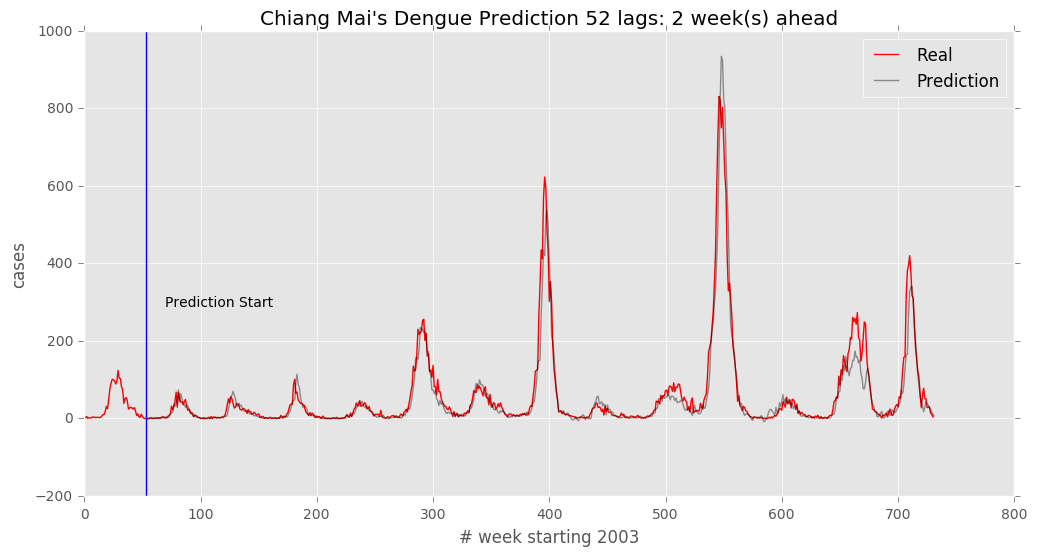

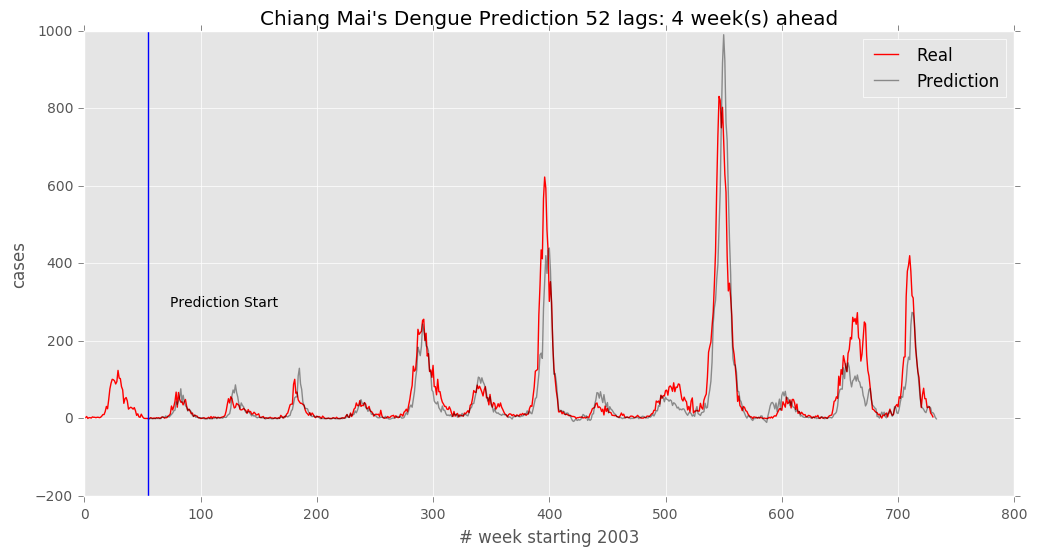

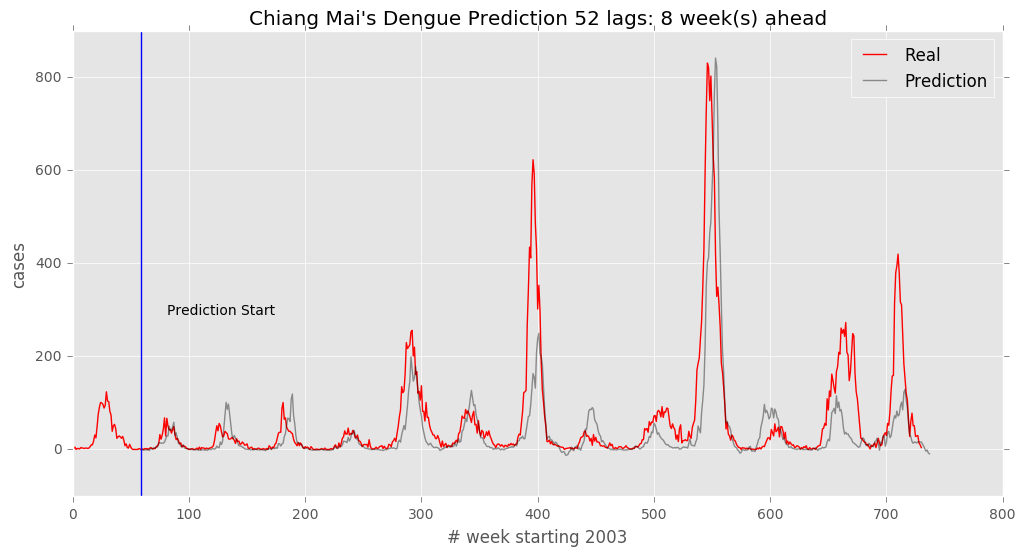

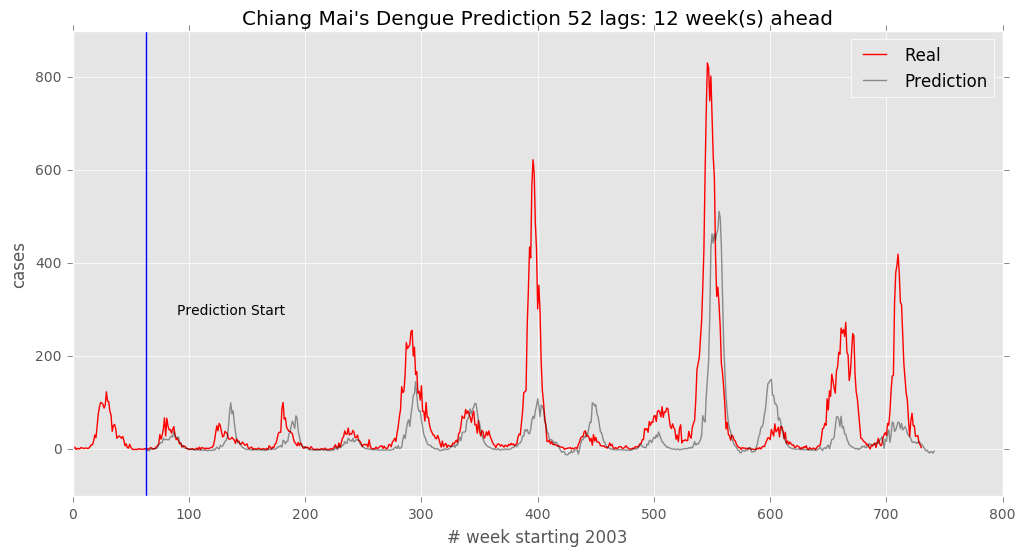

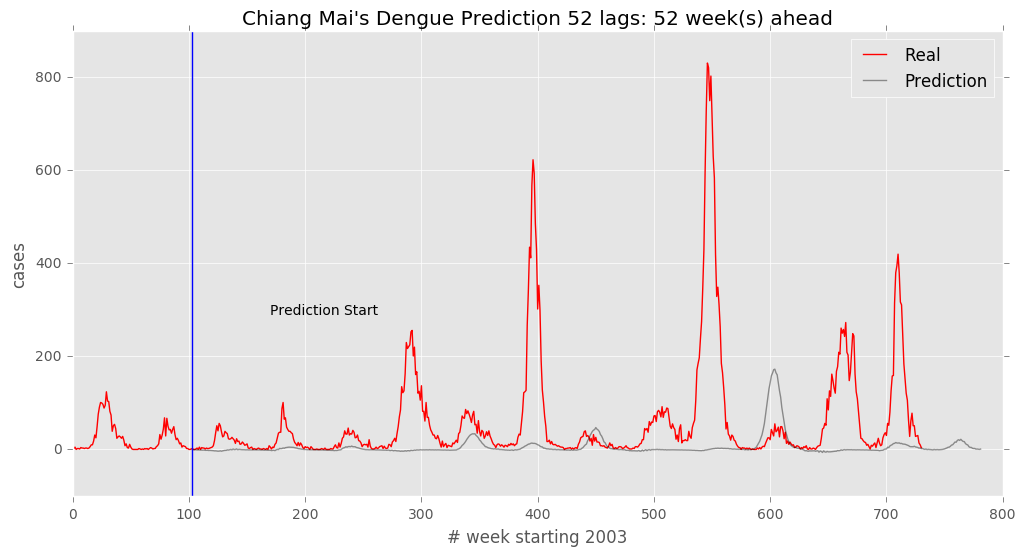

In [232]:
plot_prediction(52,cm_dengues_df.cases,cm_52.x,"Chiang Mai")


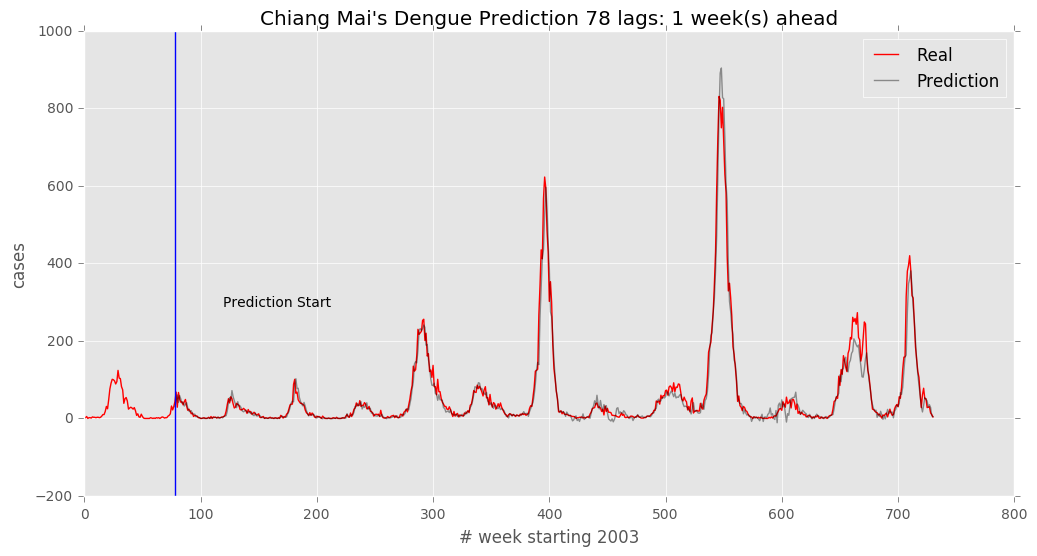

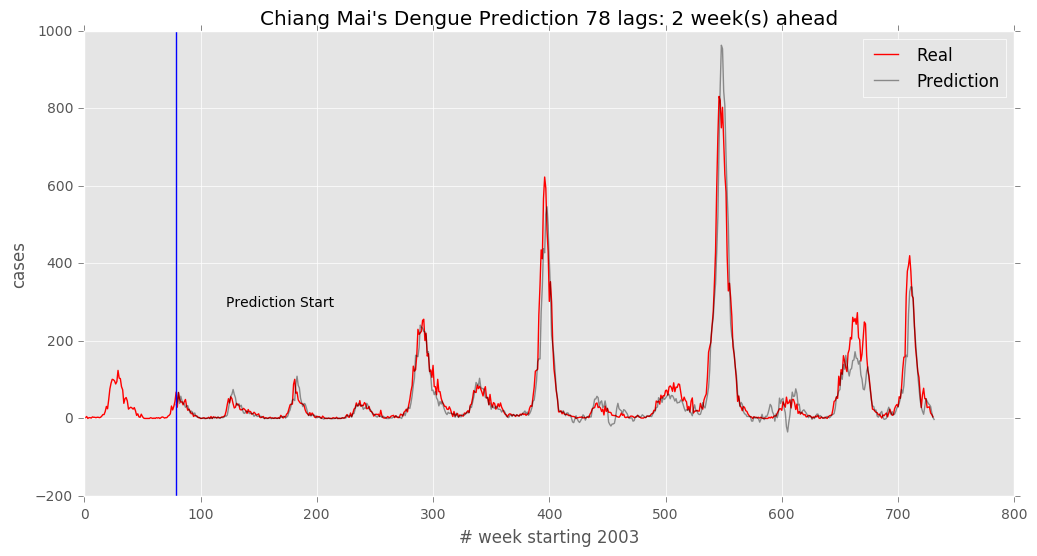

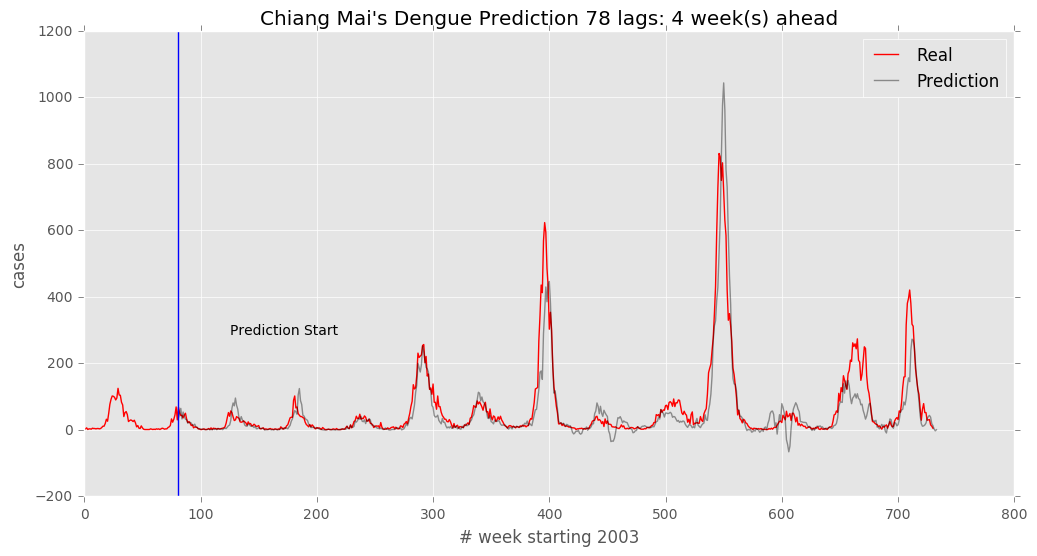

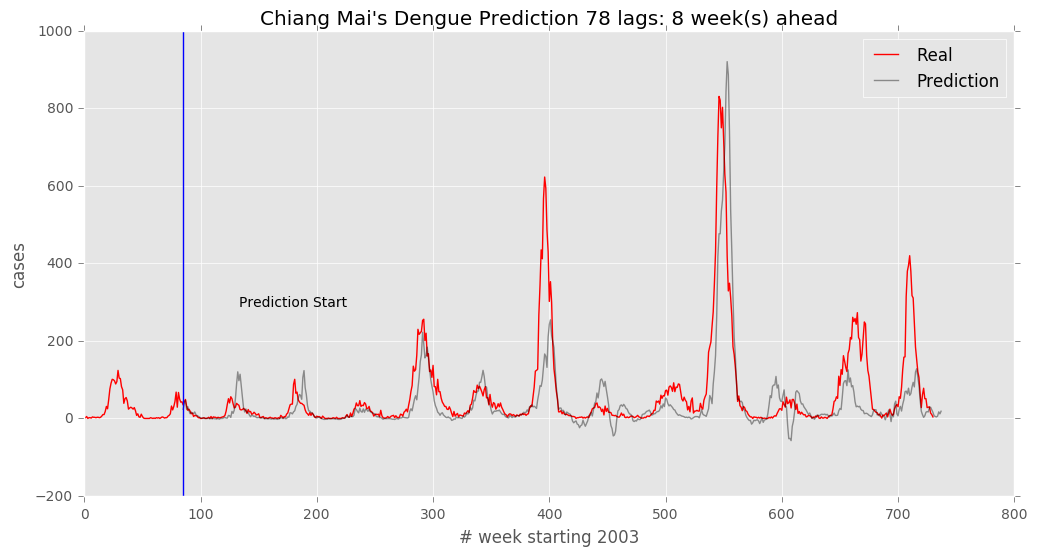

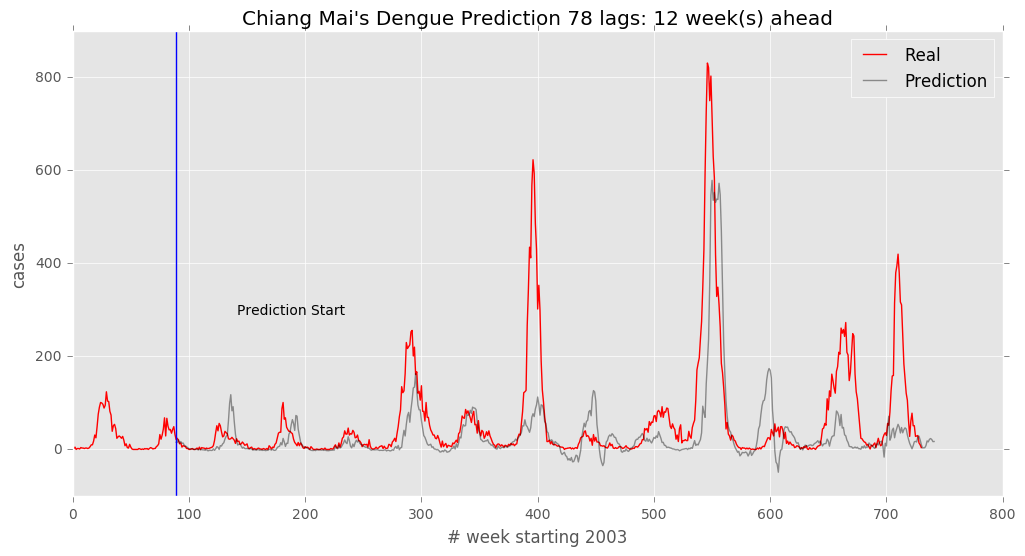

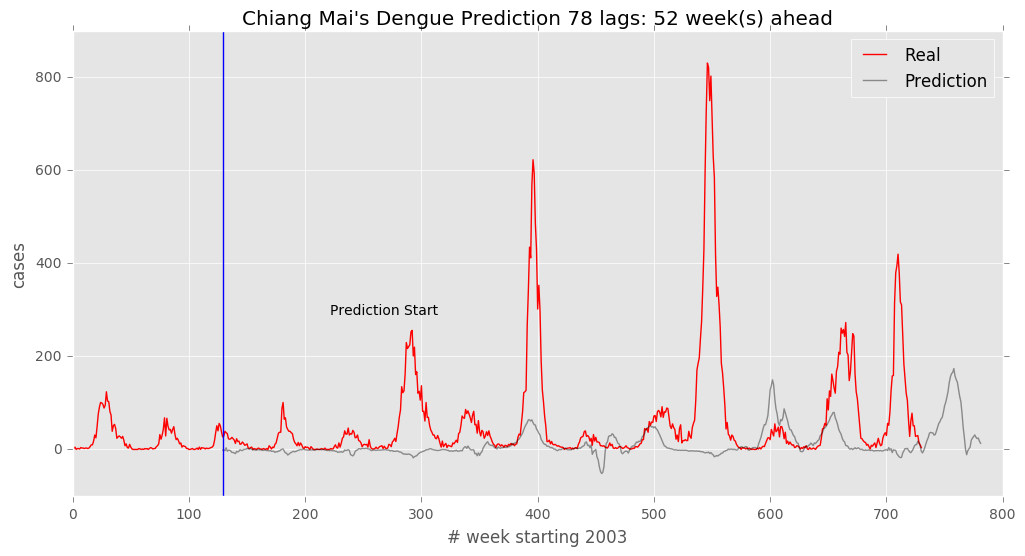

In [233]:
plot_prediction(78,cm_dengues_df.cases,cm_78.x,"Chiang Mai")

In [204]:
# cm_dengues_df.cases.plot()

In [257]:
real_ = [i+1 for i in range(30)]
nwks = 5
nweek_predict = [2]
for i in nweek_predict:
        n = nwks + (i - 1)
#         predictions = []
        print 'n',n
        for j in range(len(real_)-nwks):
            initial_arr = real_[j:j+nwks]
#             predictions.append(n_week_ahead(initial_arr,i))
            print initial_arr

n 6
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9, 10]
[7, 8, 9, 10, 11]
[8, 9, 10, 11, 12]
[9, 10, 11, 12, 13]
[10, 11, 12, 13, 14]
[11, 12, 13, 14, 15]
[12, 13, 14, 15, 16]
[13, 14, 15, 16, 17]
[14, 15, 16, 17, 18]
[15, 16, 17, 18, 19]
[16, 17, 18, 19, 20]
[17, 18, 19, 20, 21]
[18, 19, 20, 21, 22]
[19, 20, 21, 22, 23]
[20, 21, 22, 23, 24]
[21, 22, 23, 24, 25]
[22, 23, 24, 25, 26]
[23, 24, 25, 26, 27]
[24, 25, 26, 27, 28]
[25, 26, 27, 28, 29]


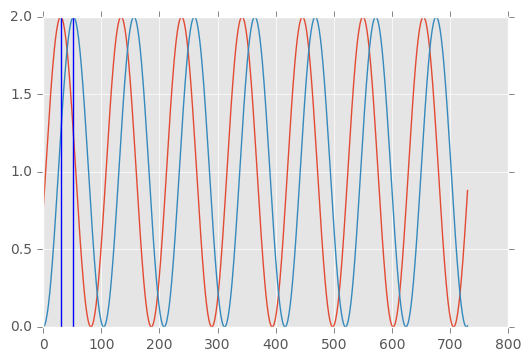

In [254]:
def cos_sq(x,const):
    coeff = np.math.pi / 52.
    inside = coeff*(x - const)
    return (np.math.cos(inside)**2)

def sine(x,const):
    coeff = np.math.pi / 52.
    inside = coeff*(x - const)
    return np.math.sin(inside) + 1

ixs = range(len(xs))
ys4 = [sine(i,4) for i in ixs] # (52/2) + 4 = 30
ys26 = [sine(i,26) for i in ixs] # (52/2) + 4 = 30
ys_sq = [cos_sq(i,30) for i in ixs]
plt.plot(ixs,ys4)
plt.plot(ixs,ys26)
# plt.plot(ixs,ys_sq)
plt.axvline(30)
plt.axvline(52)